# Introduction to TensorFlow and Keras

In this notebook we will go through the bare bones of creating a new neural network using Keras and TensorFlow. then we will recreate some of the 2 input, 1 output neural networks that we have been using before. The main purpose of this is to illustrate how much easier it is to do this in Keras than in our homebrew neural networks.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf   #Import the TensorFlow library as tf
from tensorflow import keras  #and import Keras from TensorFlow


import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

#Added for a progress bar
from tqdm.notebook import tqdm
import imageio #For image download


#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch

## Define our neural network

In [2]:
model=keras.Sequential()  #Sequential is a standard layered neural network
model.add(keras.layers.Input(shape=(2,)))
model.add(keras.layers.Dense(60,activation='relu')) #Add a fully-connected (Dense) layer  of 60 nodes with 2 input nodes
model.add(keras.layers.Dense(100,activation='relu')) #Add a 2nd fully-connected (Dense) layer with 100 nodes
model.add(keras.layers.Dense(60,activation='relu')) #Add a 3rd fully-connected (Dense) layer with 60 nodes
model.add(keras.layers.Dense(1,activation='relu'))  #A single node in the output layer


## Compile the network

In [3]:
model.compile(loss="mean_squared_error",optimizer=keras.optimizers.SGD(learning_rate=0.1),metrics=['accuracy']) 
#Compile the network with mean squared error loss function
# and stochastic gradient descent optimiser with learning rate of 0.1

#Alternative better optimiser
#model.compile(loss="mean_squared_error",optimizer='adam',metrics=['accuracy']) #adam is more sophisticated optimiser



## Read in our image
Now we need to read in our image and flip it around so that the bottom left corner can be indexed as 0,0

In [4]:
input_img = imageio.v2.imread('http://www.hep.ucl.ac.uk/undergrad/0056/other/313px-William_Henry_Bragg_Nobel_bw.jpg')
pixel_image=np.transpose(input_img) # have to transpose...
pixel_image=pixel_image[:,::-1] # and flip... to get the right view!
pixel_image-=pixel_image.min()
pixel_image=(pixel_image.astype(dtype='float'))/pixel_image.max() # normalize between 0 and 1!
Npixels=np.shape(pixel_image) 
print(Npixels[0])
print(Npixels[1])
print("The image is "+str(np.shape(pixel_image)[0])+" X "+str(np.shape(pixel_image)[1])+" pixels")

313
480
The image is 313 X 480 pixels


## Sample the image
The following two functions are used to randomly select pixel values from the image

In [5]:
#Now need to wrap the image in a function for easy calling
def imgFunction(x,y):
    global pixel_image,Npixels
    # convert to integer coordinates (assuming input is 0..1)
    xint=(x*Npixels[0]*0.9999).astype(dtype='int')
    yint=(y*Npixels[1]*0.9999).astype(dtype='int')
    return(pixel_image[xint,yint]) # extract color values at these pixels

In [6]:
#This function picks batchsize random x,y pairs and then evaluates myFunc for these x,y pairs
# returns both the x,y pairs and the values
def make_batch(batchsize):
    inputs=np.random.uniform(low=0,high=1,size=[batchsize,2])
    targets=np.zeros([batchsize,1]) # must have right dimensions
    targets[:,0]=imgFunction(inputs[:,0],inputs[:,1])
    return(inputs,targets)

## Train the network
Now we need to train the network. The configurable parameters here are the batchsize (number of random samples per step) and number of batches (number of steps).

In [7]:
batchsize=2000
batches=2000
costs=np.zeros(batches)
for k in tqdm(range(batches)): #tqdm provides a handy progress bar
    y_in,y_target=make_batch(batchsize) 
    costs[k]=model.train_on_batch(y_in,y_target)[0]
 

  0%|          | 0/2000 [00:00<?, ?it/s]

Text(0, 0.5, 'Cost')

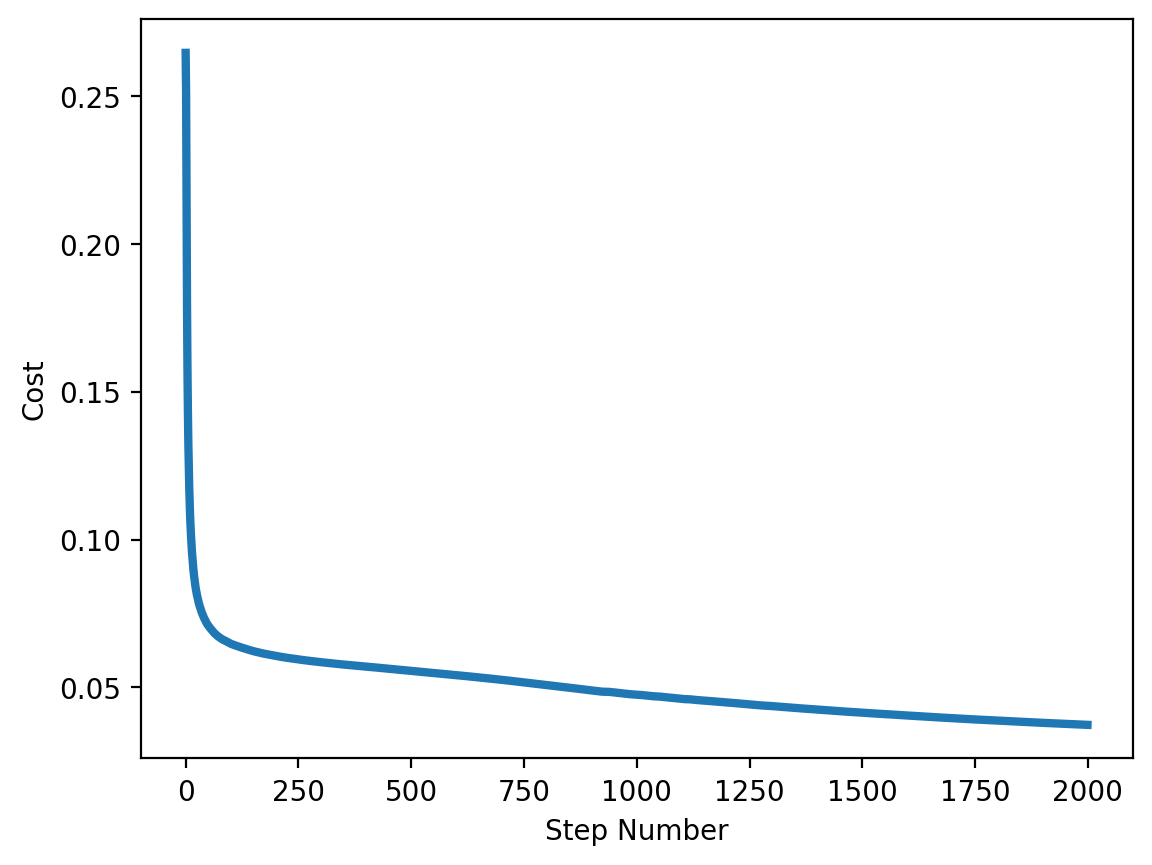

In [8]:
#Plot the cost
fig, ax = plt.subplots()
stepArray=np.arange(batches) 
ax.plot(stepArray,costs,linewidth=3) 
ax.set_xlabel("Step Number")
ax.set_ylabel("Cost")

## Test the network
Now, I'll be honest the following cell took me a long time to get correct. It is conceptually simple we have an image that is 313 X 480 pixels and we need to reshape the 313 x values and 480 y values, into an array that is 150,240 x 2 to feed into the neural network (note this is not the ideal way to train a neural network on an image).

Then we can plot our image and try and guess what it is.

In [9]:
xrange=np.linspace(0,1,Npixels[0]) #e.g. 50 steps from 0,1
yrange=np.linspace(0,1,Npixels[1]) #e.g. 50 steps from 0,1
X0,X1=np.meshgrid(xrange,yrange) #get the 2D grid points
numpixels=np.shape(X0)[0]*np.shape(X0)[1]
y_in=np.reshape(np.transpose([X0,X1]),(numpixels,2))
print(np.shape(y_in))
#y_fake=y_in[:,0]*y_in[:,1]  #I used this to test I was doing the reshaping
#print(np.shape(y_fake))

y_out=model.predict_on_batch(y_in)
pixels=np.transpose(np.reshape(y_out,(np.shape(X0)[1],np.shape(X0)[0])))
print(np.shape(pixels))

(150240, 2)
(480, 313)


(np.float64(-0.5), np.float64(312.5), np.float64(-0.5), np.float64(479.5))

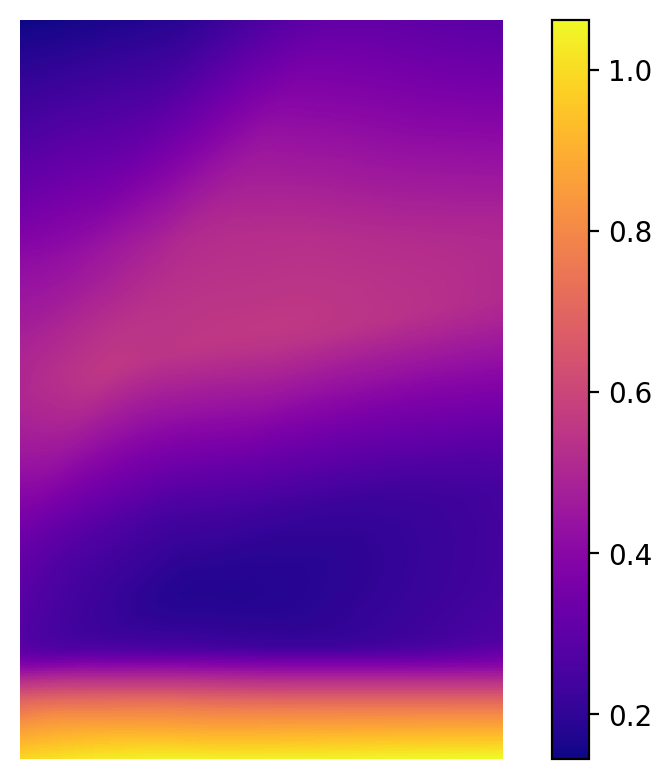

In [10]:
fig, ax = plt.subplots()  #I like to make plots using this silly fig,ax method but plot how you like
im=ax.imshow(pixels,interpolation='nearest',origin='lower',cmap='plasma')
cb = fig.colorbar(im) #Get the colorbar for the range of z values
ax.axis('off')

## The input image
So what did the input image look like?

(np.float64(-0.5), np.float64(312.5), np.float64(-0.5), np.float64(479.5))

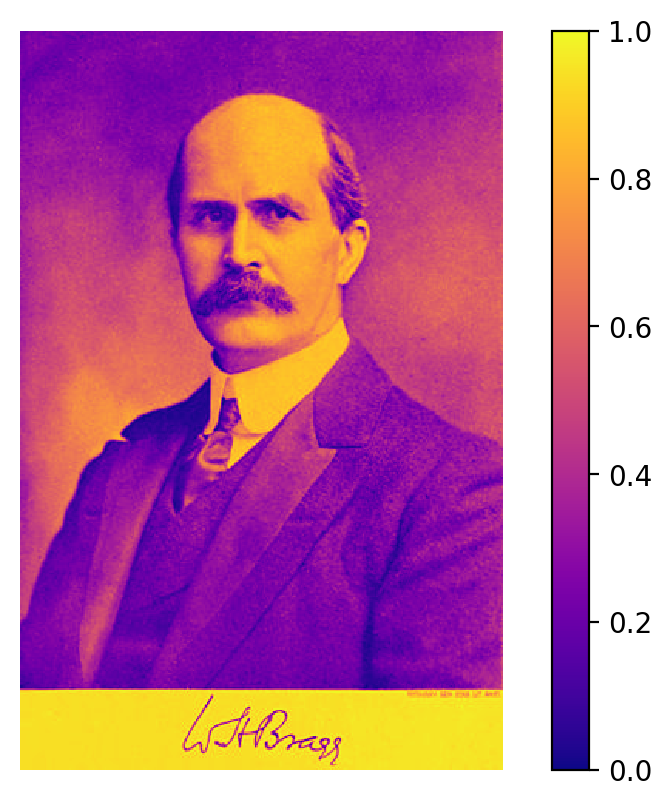

In [11]:
# Check that we can actually plot the image
xrange=np.linspace(0,1,Npixels[0]) #e.g. 50 steps from 0,1
yrange=np.linspace(0,1,Npixels[1]) #e.g. 50 steps from 0,1
X0,X1=np.meshgrid(xrange,yrange) #get the 2D grid points
fig, ax = plt.subplots()  #I like to make plots using this silly fig,ax method but plot how you like
im=ax.imshow(imgFunction(X0,X1),interpolation='nearest',origin='lower',cmap='plasma')
cb = fig.colorbar(im) #Get the colorbar for the range of z values
ax.axis('off')

## Suggested tasks
Can you make a better image reproduction?